In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Input, Dense,Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

In [4]:
# 변수 정의
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [5]:
def sampling(args:tuple):
    z_mean, z_log = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    return z_mean+ K.exp(z_log / 2)*epsilon

In [7]:
# 인코더 정의
x = Input(shape=(original_dim,), name='input')
# 중간층  256
h = Dense(intermediate_dim,activation='relu',name='encoding')(x)
# 잠재공간의 평균 2
z_mean = Dense(latent_dim, name = 'mean')(h)
# 잠재공간의 로그 분산을 정의
z_log_var = Dense(latent_dim,name='log-variance')(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var])
encoder = Model(x, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [8]:
# 디코더 정의 2
input_decoder = Input(shape=(latent_dim,),name='decoder_input')
# 잠재공간의 중간층으로 변환  256
decoder_h = Dense(intermediate_dim, activation='relu',name='decoder_h')(input_decoder)
x_decoder = Dense(original_dim, activation='sigmoid',name='falt_decoded')(decoder_h)
decoder = Model(input_decoder,x_decoder, name = 'decoder')
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 falt_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 변이형 오토인코더(VAE)
# 인코더의 출력을 디코더에서 사용  인코더의 3번째 반환값이 z
output_combined = decoder(encoder(x)[2])
# 입력과 출력을 연결
vae = Model(x, output_combined)
vae.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 손실 정의 하고 모델 실행
# KL손실  크로스 엔트로피
kl_loss = -0.5*K.sum(
    1+z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1
)
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop',loss = 'binary_crossentropy')
vae.summary()
             

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                              

In [19]:
#훈련 데이터
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape( len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape( len(x_test), np.prod(x_test.shape[1:]))

In [20]:
vae.fit(x_train,x_train,shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 6s 9ms/step - loss: 0.2437
Epoch 2/50
600/600 [==============================] - 6s 10ms/step - loss: 0.2168
Epoch 3/50
600/600 [==============================] - 6s 9ms/step - loss: 0.2131
Epoch 4/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2103
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2083
Epoch 6/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2069
Epoch 7/50
600/600 [==============================] - 6s 10ms/step - loss: 0.2057
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2047
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2039
Epoch 10/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2031
Epoch 11/50
600/600 [==============================] - 4s 6ms/step - loss: 0.2025
Epoch 12/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2019
Epoch 13/50
600/600 [==

In [21]:
import matplotlib.pyplot as plt

100/100 [==============================] - 0s 2ms/step


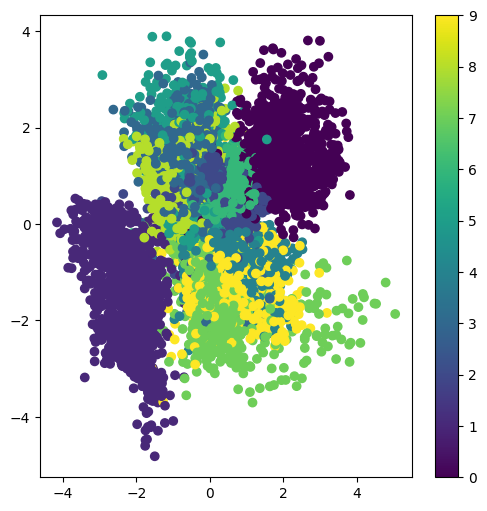

In [22]:
# 모델을  사용해 데이터  생성하기
x_test_encoded =  encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

In [23]:
# 만들기
# 보간을 위한 그리드를 만들기위해서 np.linespace를 사용해서 step_size 간격으로 min max사이를 이동
# for 반복문에서 각 숫자 샘플을 생성하고 출력

1/1 [==============================] - 0s 20ms/step


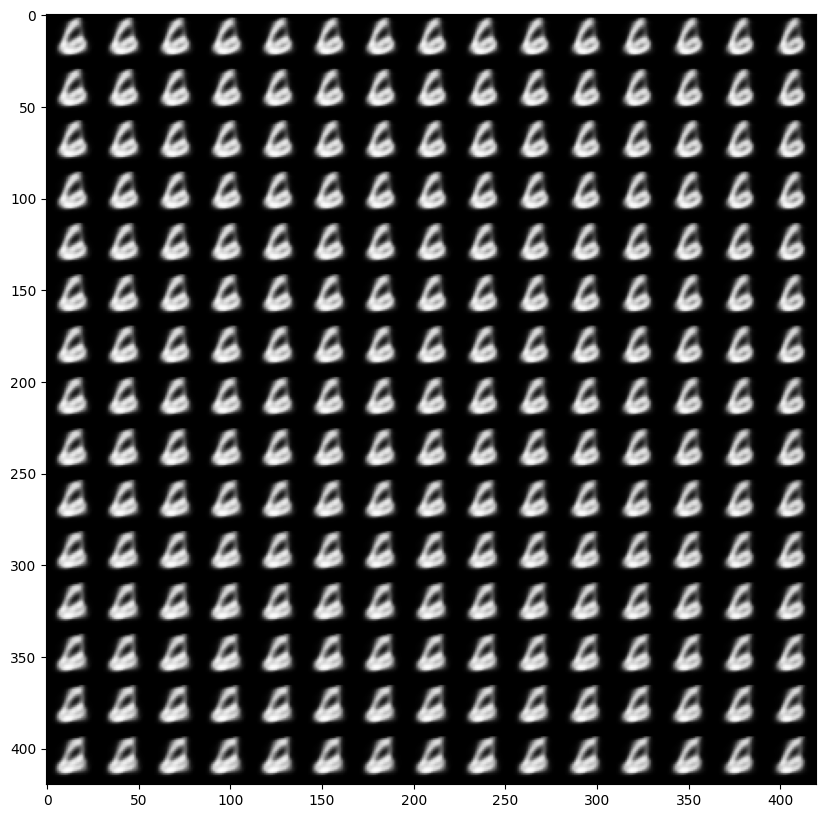

In [26]:
# 숫자의 2D 매니폴드 출력
n = 15  # 15 x 115 숫자를 담는 그림
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
# 잠재공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기위 해서
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppt)통해 변환
grid_x = norm.pdf(np.linspace(0.05,0.95,n))
grid_y = norm.pdf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[ i*digit_size:(i+1)*digit_size,
               j*digit_size:(j+1)*digit_size] = digit
plt.figure(figsize=(10,10))
plt.imshow(figure,cmap='Greys_r')
plt.show()